<a href="https://colab.research.google.com/github/marcmontb/Neural-Style/blob/main/Neural_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Setup
First, ensure you have the required libraries installed. You can install them using the following commands:

In [ ]:
!pip install torch torchvision pillow matplotlib

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

# Step 2: Import Libraries
Create a new cell in your Jupyter notebook and import the necessary libraries:

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Import content and style images

In [13]:
from google.colab import files
uploaded = files.upload()

# Step 3: Image Preprocessing
We define a function to load and preprocess images. The preprocessing involves resizing the image, converting it to a tensor, and normalizing it with mean and standard deviation values from the ImageNet dataset.

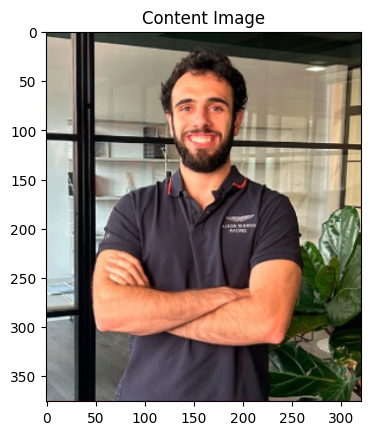

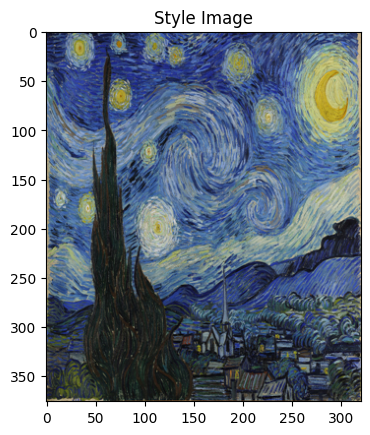

In [16]:
import numpy as np  # Import NumPy

def image_loader(image_path, max_size=400, shape=None):
    image = Image.open(image_path).convert('RGB')

    # Resize the image
    size = max_size if max(image.size) > max_size else max(image.size)
    if shape is not None:
        size = shape

    transform = transforms.Compose([
        transforms.Resize(size),  # Resize the image to the desired size
        transforms.ToTensor(),  # Convert the image to a PyTorch tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image using ImageNet mean and std
    ])

    image = transform(image).unsqueeze(0)  # Add a batch dimension
    return image.to(device, torch.float)

# Load and preprocess the content and style images
content_image = image_loader('/content/1-content.png')
style_image = image_loader('/content/1-style.jpg', shape=[content_image.size(2), content_image.size(3)])

# Display the images
def imshow(tensor, title=None):
    image = tensor.cpu().clone().squeeze(0).detach().numpy()  # Convert tensor to numpy array
    image = image.transpose(1, 2, 0)  # Transpose dimensions to HWC (height, width, channels)
    mean = np.array([0.485, 0.456, 0.406])  # ImageNet mean
    std = np.array([0.229, 0.224, 0.225])  # ImageNet std
    image = std * image + mean  # De-normalize the image
    image = np.clip(image, 0, 1)  # Clip values to the range [0, 1]

    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.show()

imshow(content_image, title='Content Image')
imshow(style_image, title='Style Image')



# Step 4: Define Loss Functions
We define the content loss and style loss functions.
The Gram matrix is used to measure style loss.

In [17]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()  # Detach target to prevent gradient computation

    def forward(self, input):
        self.loss = nn.functional.mse_loss(input, self.target)  # Compute mean squared error loss
        return input

def gram_matrix(input):
    a, b, c, d = input.size()  # Batch size, number of feature maps, height, width
    features = input.view(a * b, c * d)  # Reshape input to 2D tensor
    G = torch.mm(features, features.t())  # Compute Gram matrix
    return G.div(a * b * c * d)  # Normalize Gram matrix

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()  # Detach target Gram matrix

    def forward(self, input):
        G = gram_matrix(input)  # Compute Gram matrix for input


# Step 5: Build the Model
We build the model using the VGG19 network and add content and style loss layers at the appropriate points.

In [19]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

content_layers = ['conv_4']  # Layers used for content representation
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']  # Layers used for style representation

class StyleTransferModel(nn.Module):
    def __init__(self, cnn, content_img, style_img, content_layers, style_layers):
        super(StyleTransferModel, self).__init__()
        self.content_losses = []
        self.style_losses = []
        self.model = nn.Sequential()

        i = 0
        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = f'conv_{i}'
            elif isinstance(layer, nn.ReLU):
                name = f'relu_{i}'
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = f'pool_{i}'
            elif isinstance(layer, nn.BatchNorm2d):
                name = f'bn_{i}'

            self.model.add_module(name, layer)

            if name in content_layers:
                target = self.model(content_img).detach()
                content_loss = ContentLoss(target)
                self.model.add_module(f'content_loss_{i}', content_loss)
                self.content_losses.append(content_loss)

            if name in style_layers:
                target_feature = self.model(style_img).detach()
                style_loss = StyleLoss(target_feature)
                self.model.add_module(f'style_loss_{i}', style_loss)
                self.style_losses.append(style_loss)

    def forward(self, x):
        self.model(x)
        content_loss = sum(cl.loss for cl in self.content_losses)
        style_loss = sum(sl.loss for sl in self.style_losses)
        return content_loss, style_loss

# Initialize the generated image
input_img = content_image.clone()


# Step 6: Define the Optimizer
We define the optimizer (LBFGS)  to update the generated image.



In [ ]:
optimizer = optim.LBFGS([input_img.requires_grad_()])


# Step 7: Perform Style Transfer
We perform the style transfer by iteratively minimizing the total loss, which is a weighted sum of content and style losses, and display the final image.


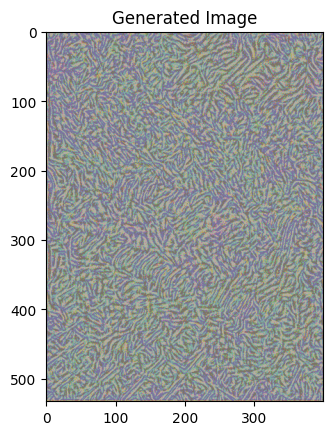

In [ ]:
style_transfer_model = StyleTransferModel(cnn, content_image, style_image, content_layers, style_layers).to(device)

num_steps = 300
style_weight = 1e6
content_weight = 1

for step in range(num_steps):
    def closure():
        input_img.data.clamp_(0, 1)  # Clamp image values to [0, 1]
        optimizer.zero_grad()  # Zero the gradients
        content_loss, style_loss = style_transfer_model(input_img)  # Forward pass
        loss = content_weight * content_loss + style_weight * style_loss  # Compute total loss
        loss.backward()  # Backward pass
        return loss

    optimizer.step(closure)  # Optimize

    input_img.data.clamp_(0, 1)  # Clamp image values to [0, 1]

# Display the final generated image
imshow(input_img, title='Generated Image')
